# DESI MWS SV ANALYSIS

* Reads the data generated by `sv_design.ipynb`

In [1]:
RUN_NAME = 'single_dark_tile'

In [2]:
# %load scripts/nbpreamble.py
if not 'RUN_NAME' in locals():
    RUN_NAME = 'unknown'

import sys
import os
import shutil
import glob
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as pl
from   matplotlib.patches import Circle, Polygon, RegularPolygon
%matplotlib inline

from desitarget.cuts import select_targets, qso_selection_options

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", module='desitarget')
    # Tries to set mpl backend
    from desitarget.QA import _parse_tcnames

from desiutil.log import get_logger

from importlib import reload

add_sys_path = list()
add_sys_path.append(os.path.join(os.getcwd(),'py'))

WITH_SPHERICAL_GEOMETRY = True
if WITH_SPHERICAL_GEOMETRY:
    add_sys_path.append(os.path.join(os.environ['HOME'],
                                 'software/modules/spherical_geometry/master/lib/python3.6/site-packages/spherical_geometry-1.2.5-py3.6-linux-x86_64.egg/'))

for _ in add_sys_path:
    if _ not in sys.path:
        sys.path.append(_)
                    
from apcsv.astropy_backports import *

if WITH_SPHERICAL_GEOMETRY:
    import spherical_geometry
    from spherical_geometry import polygon as spoly

import astropy
import astropy.units as u
import astropy.coordinates as coord
import regions
from   astropy.io import fits
from   astropy.table import Table, Column

import desiutil
import desiutil.plots
import desimodel
import desimodel.focalplane
import desitarget

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning, module="matplotlib")
    # Tries to set mpl backend
    import desitarget
import desitarget.io as io
import desitarget.mtl

import desitarget.targetmask
from   desitarget.targetmask import desi_mask, bgs_mask, mws_mask, obsmask, obsconditions

import fitsio

def warning_summary(W):
    if len(W) == 0:
        print('No warnings')
        return
    
    import collections
    d = collections.defaultdict(lambda: 0)
    for _ in W: d[_.category.__name__] += 1
        
    print('{:15s} {:s}'.format('WARNING','COUNT'))
    for k,v in d.items():
        print('{:15s} {:d}'.format(k,v))
        
!date
for m in [astropy,np]:
    print('{:15s} {:20s}'.format(m.__name__,m.version.version))
for m in [desitarget,desimodel]:
    print('{:15s} {:20s}'.format(m.__name__,m._version.__version__))
!echo 'fiberassign    ' $(fiberassign_exec --version)   

print()
print('Path to fiberassign_exec:')
!which fiberassign_exec

print()
print('Working dir:', os.getcwd())

# Write all the files under this path
ROOT_DIR  = os.getcwd()
WORK_ROOT = os.path.join(ROOT_DIR,'runs',RUN_NAME)
print('Files will be written under {}'.format(WORK_ROOT))

if not os.path.exists(WORK_ROOT):
    os.makedirs(WORK_ROOT)
    
print()
print('Files under this directory:')
!tree --noreport -C --filelimit 10 -I '*.py*' $ROOT_DIR

print()
print('Files under the run directory:')
!date
!tree --noreport -C -D --filelimit 10 $WORK_ROOT/run

print()
print('Useful numbers:')
R_TILE = desimodel.focalplane.get_tile_radius_deg()
A_TILE = np.pi*R_TILE**2
print('Tile radius: {:4.3f} deg'.format(R_TILE))
print('Tile area:   {:4.3f} sq.deg.'.format(A_TILE))

# Set up paths
rundir   = os.path.join(WORK_ROOT,'run')
datadir  = os.path.join(rundir,'data')
outdir   = os.path.join(rundir,'output')

for _dir in [rundir,datadir,outdir]:
    os.makedirs(_dir,exist_ok=True)  
    
resource_paths = {
     "skies"  : "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/", 
     "gfas"   : "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/",
}

resource_names = {
    "skies"   : "dr7.1-0.22.0.fits", 
    "gfas"    : "dr7.1.fits",
}

mtl_path           = os.path.join(datadir, 'mtl.fits')
std_path           = os.path.join(datadir, 'std.fits')
local_targets_path = os.path.join(datadir, 'sv_targets.fits')

sky_path     = os.path.join(resource_paths["skies"], 
                          "skies-{}".format(resource_names["skies"]))
gfa_path     = os.path.join(resource_paths["gfas"], 
                          "gfas-{}".format(resource_names["gfas"]))

Sun Dec  9 02:09:10 PST 2018
astropy         2.0.7               
numpy           1.13.3              
desitarget      0.25.0.dev2587      
desimodel       0.9.9.dev464        
fiberassign     0.10.3.dev2254

Path to fiberassign_exec:
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/fiberassign/master/bin/fiberassign_exec

Working dir: /global/u1/a/apcooper/projects/mws_svplan
Files will be written under /global/u1/a/apcooper/projects/mws_svplan/runs/single_dark_tile

Files under this directory:
/global/u1/a/apcooper/projects/mws_svplan
├── cache
│   └── sweeps
│       └── 7.1 [292 entries exceeds filelimit, not opening dir]
├── py
│   └── apcsv
│       └── __pycache__
├── runs
│   ├── single_dark_tile
│   │   ├── run
│   │   │   ├── data
│   │   │   │   ├── mtl.fits
│   │   │   │   ├── std.fits
│   │   │   │   └── sv_targets.fits
│   │   │   └── output
│   │   │       └── tile_00000.fits
│   │   └── tiles
│   │       └── mws_sv_tiles.fits
│   ├── single_hex_bright


Patch in our own targetmask (for analysis, no need to patch the cut logic).

In [3]:
import apcsv.patch
reload(apcsv.patch)
from apcsv.patch import patch_desitarget_bits

# Restores targetmask to default
reload(desitarget)
reload(desitarget.targetmask)

# Patch with our definitions
new_yaml = os.path.join(ROOT_DIR,'targetmasks/mws_sv_fix_targetmask.yaml')
desi_mask, bgs_mask, mws_mask, obsmask, obsconditions = patch_desitarget_bits(desitarget,
                                                                              new_yaml)

In [4]:
import apcsv.util
reload(apcsv.util)
import apcsv.fiberqa
reload(apcsv.fiberqa)

<module 'apcsv.fiberqa' from '/global/u1/a/apcooper/projects/mws_svplan/py/apcsv/fiberqa.py'>

In [5]:
# Read the MTL
mtl = fitsio.read(mtl_path)

In [6]:
# Read the outputs of the fiberassign python script (post-processed/value-added 
# versions of raw output from fiberassign_exec). There are 3 extensions.
fib = apcsv.fiberqa.load_fiber_data(outdir,'FIBERASSIGN')
pot = apcsv.fiberqa.load_fiber_data(outdir,'POTENTIAL')
tgt = apcsv.fiberqa.load_fiber_data(outdir,'TARGETS')

Have 1 tiles
Have 1 tiles
Have 1 tiles


Analysis of a single tile.

In [7]:
t = Table(fib[0])
t[0:2]

FIBER,LOCATION,NUMTARGET,PRIORITY,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,TARGET_RA,TARGET_DEC,DESIGN_X,DESIGN_Y,BRICKNAME,FIBERSTATUS,DESIGN_Q,DESIGN_S,LAMBDA_REF,OBJTYPE,PETAL_LOC,DEVICE_LOC,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTSTARINBLOB,PHOTSYS,SUBPRIORITY,HPXPIXEL,NUMOBS_MORE,OBSCONDITIONS
int32,int32,int16,int32,int64,int64,int64,int64,float64,float64,float32,float32,str8,int32,float32,float32,float32,str3,int16,int32,int32,int32,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,bool,str1,float64,int64,int32,int32
0,95,7,1400,30787732330513117,2305843009213693952,0,49,177.108300497,0.661354194557,-6.17873,-179.461,1771p007,0,268.028,179.612,5400.0,TGT,0,95,7000,335396,733,PSF,1.03369e+14,2.1322e+14,235065.0 .. 0.0,0.027335,9.79204,30.2757,56.0061,26.7381,13.1388,50.983,-442.376,259.426,104.365,36.5154,2.60771,0.502723,0.000741902,1.63944e-05,0.92227,0.946952,0.969971,0.995378,0.997159,0.999393,0.999771,2,2,2,6.31027e-06,1.44391e-06,2.81692e-06,0.00882614,0.0101011,0.0185993,0.997444,0.99723,0.664524,0,0,0,500.671,447.658,76.5903,366.643,226.355,38.4101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.94681,21.4787,39.7327,6.94682,21.4787,39.7328,3796055064444103808,18.9648,312.219,19.6476,19.5145,18.0507,64.114,0.676312,False,1.01217,5.59626,21.164,1.27976,-58.4705,5.22998,False,S,0.953279672233,26972,1,7
1,62,6,2000,30787732334709212,3458764513820540928,263172,114688,177.29154446,0.747675276661,-51.0565,-158.089,1773p007,0,252.102,166.164,5400.0,TGT,0,62,7000,335397,2524,PSF,5.55273e+13,1.7229e+14,159673.0 .. 0.0,0.0256907,14.5701,17.7944,14.048,36.4541,64.6189,183.435,373.802,327.651,227.272,92.02,2.63427,0.512262,0.000814155,1.93959e-05,0.92677,0.950062,0.971752,0.995656,0.99733,0.99943,0.999785,3,3,4,5.97262e-05,9.36598e-05,0.000560868,0.00305709,0.00951059,0.0245618,0.998517,0.999242,0.995536,0,0,0,825.076,610.004,113.459,581.879,327.578,60.9108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.3287,13.8357,10.9228,11.3287,13.8358,10.923,3796080185708458368,19.5691,125.412,19.4273,23.2605,19.0372,19.0746,0.0,False,0.322422,3.25928,-0.169086,1.06061,0.580718,3.88391,False,S,0.743796182287,26972,1,7


In [8]:
# Report numbers for each raw MWS bit
print('{:10s} {:10s}'.format('MWS_TARGET','NTARGETS'))
for a,b in zip(*np.unique(t['MWS_TARGET'],return_counts=True)):
    print('{:<10d} {:<10d} {:s}'.format(a,b,' & '.join(mws_mask.names(a))))

MWS_TARGET NTARGETS  
0          1210       
4          27         MWS_NEARBY
6          1          MWS_WD & MWS_NEARBY
49         1095       MWS_BROAD & MWS_BROAD_NORTH & MWS_BROAD_SOUTH
53         15         MWS_BROAD & MWS_NEARBY & MWS_BROAD_NORTH & MWS_BROAD_SOUTH
1792       2109       MWS_MAIN_BLUE & MWS_MAIN_BLUE_NORTH & MWS_MAIN_BLUE_SOUTH
1794       16         MWS_WD & MWS_MAIN_BLUE & MWS_MAIN_BLUE_NORTH & MWS_MAIN_BLUE_SOUTH
14336      290        MWS_MAIN_RED & MWS_MAIN_RED_NORTH & MWS_MAIN_RED_SOUTH
114688     193        MWS_MAIN_BLUE_FAINT & MWS_MAIN_BLUE_FAINT_NORTH & MWS_MAIN_BLUE_FAINT_SOUTH
114690     22         MWS_WD & MWS_MAIN_BLUE_FAINT & MWS_MAIN_BLUE_FAINT_NORTH & MWS_MAIN_BLUE_FAINT_SOUTH
917504     14         MWS_MAIN_RED_FAINT & MWS_MAIN_RED_FAINT_NORTH & MWS_MAIN_RED_FAINT_SOUTH
917506     2          MWS_WD & MWS_MAIN_RED_FAINT & MWS_MAIN_RED_FAINT_NORTH & MWS_MAIN_RED_FAINT_SOUTH
917508     6          MWS_NEARBY & MWS_MAIN_RED_FAINT & MWS_MAIN_RED_FAINT_NORTH 

In [9]:
# Report numbers for each raw DESI bit
is_mws = t['MWS_TARGET'] > 0 

print('MWS targets')
print('{:20s} {:10s}'.format('DESI_TARGET','NTARGETS'))
for a,b in zip(*np.unique(t['DESI_TARGET'][is_mws],return_counts=True)):
    print('{:<20d} {:<10d} {:s}'.format(a,b,' & '.join(desi_mask.names(a))))
    
print()
print('Other targets')
print('{:20s} {:10s}'.format('DESI_TARGET','NTARGETS'))
for a,b in zip(*np.unique(t['DESI_TARGET'][~is_mws],return_counts=True)):
    print('{:<20d} {:<10d} {:s}'.format(a,b,' & '.join(desi_mask.names(a))))

MWS targets
DESI_TARGET          NTARGETS  
2305843009213693952  2981       MWS_ANY
2305843017803628544  246        STD_FAINT & MWS_ANY
2305843026393563136  38         STD_WD & MWS_ANY
2305843052163366912  246        STD_FAINT & STD_BRIGHT & MWS_ANY
3458764513820540928  275        BGS_ANY & MWS_ANY
3458764522410475520  1          STD_FAINT & BGS_ANY & MWS_ANY
3458764531000410112  3          STD_WD & BGS_ANY & MWS_ANY

Other targets
DESI_TARGET          NTARGETS  
0                    7          
4294967296           1162       SKY
34359738368          36         STD_BRIGHT
42949672960          5          STD_FAINT & STD_BRIGHT


In [10]:
# Report on targets classified as both MWS and non-MWS
reload(apcsv.fiberqa)
apcsv.fiberqa.report_survey_overlaps(t)

809 fibers with both MWS and non-MWS target bits:
 BGS_ANY                         275 BROAD (RED REJECT) | BLUE | RED | BLUE FAINT | RED FAINT
 STD_FAINT                       246 BLUE
 STD_FAINT & BGS_ANY               1 BLUE
 STD_FAINT & STD_BRIGHT          246 BLUE
 STD_WD                           38 WD & NEARBY | BLUE & WD | BLUE FAINT & WD | RED FAINT & WD
 STD_WD & BGS_ANY                  3 BLUE & WD | BLUE FAINT & WD


In [11]:
# Report numbers for each priority
print('{:10s} {:10s}'.format('PRIORITY','NTARGETS'))
for a,b in reversed(list(zip(*np.unique(t['PRIORITY'],return_counts=True)))):
    print('{:<10d} {:<10d}'.format(a,b))

PRIORITY   NTARGETS  
2998       41        
2100       8         
2000       268       
1600       48        
1500       2173      
1400       1093      
1          1369      


No warnings


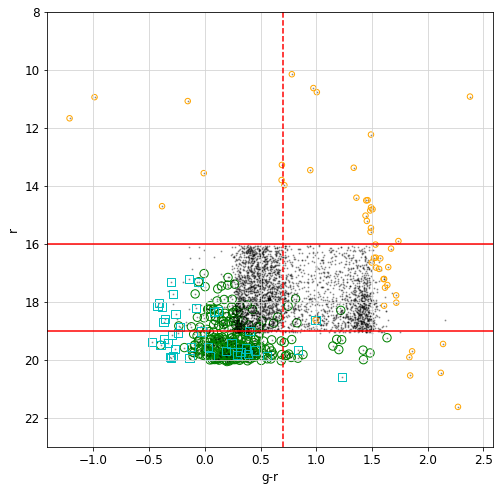

In [106]:
# Colour-magnitude plot
pl.figure(figsize=(8,8))
with warnings.catch_warnings(record=True) as W:
    #warnings.filterwarnings("ignore",category=RuntimeWarning)
    g = -2.5*np.log10(t['FLUX_G'])+22.5
    r = -2.5*np.log10(t['FLUX_R'])+22.5
    pl.scatter(g-r,r,s=1,alpha=0.3,c='k')
    
    is_nearby = t['MWS_TARGET'] & mws_mask['MWS_NEARBY'] != 0 
    pl.scatter((g-r)[is_nearby],r[is_nearby], s=30, facecolor='None',edgecolor='orange')

    is_wd = t['MWS_TARGET'] & mws_mask['MWS_WD'] != 0 
    pl.scatter((g-r)[is_wd],r[is_wd], s=70, facecolor='None',edgecolor='c',marker='s')
    
    is_bgs =  t['BGS_TARGET'] != 0 
    pl.scatter((g-r)[is_bgs],r[is_bgs], s=70, facecolor='None',edgecolor='g',marker='o',zorder=-10)
warning_summary(W)

pl.xlabel('g-r',fontsize=12)
pl.ylabel('r',fontsize=12)
pl.axhline(19,c='r')
pl.axhline(16,c='r')
pl.axvline(0.7,c='r',ls='--') # RED/BLUE separation
pl.ylim(23,8)
pl.grid(c='lightgrey')

ax = pl.gca()
pl.tick_params(labelsize=12)


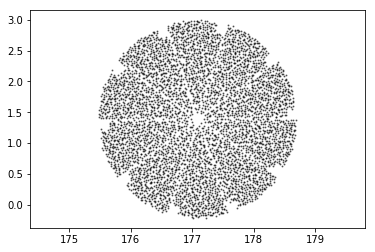

In [99]:
# Sky plot -- all fibers
pl.scatter(t['TARGET_RA'],t['TARGET_DEC'],c='k',s=1,alpha=0.5)
pl.axis('equal');

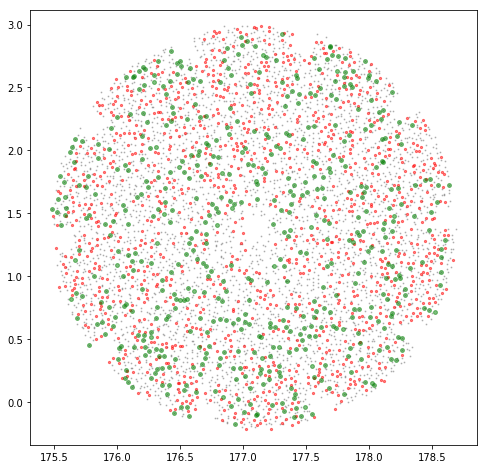

In [14]:
# Sky plot -- MWS SV, skys, stds

pl.figure(figsize=(8,8))

is_mws = t['MWS_TARGET'] > 0
is_sky = t['DESI_TARGET'] & desi_mask.mask('SKY') != 0 
is_std = (t['DESI_TARGET'] & desi_mask.mask('STD_FAINT')) | (t['DESI_TARGET'] & desi_mask.mask('STD_BRIGHT')) != 0

_ = is_mws
pl.scatter(t['TARGET_RA'][_],t['TARGET_DEC'][_],c='k',s=1,alpha=0.2)
pl.axis('equal');

_ = is_sky
pl.scatter(t['TARGET_RA'][_],t['TARGET_DEC'][_],c='r',s=5,alpha=0.5)
pl.axis('equal');

_ = is_std
pl.scatter(t['TARGET_RA'][_],t['TARGET_DEC'][_],c='g',s=15,alpha=0.5)
pl.axis('equal');

In [33]:
ra  = t['TARGET_RA']
dec = t['TARGET_DEC']

ra_min  = ra.min()
ra_max  = ra.max()
dec_min = np.radians(dec.min())
dec_max = np.radians(dec.max())

# Convert the maximum pixel area to steradians.
max_bin_area = (5.0/60.0)**2
max_bin_area = max_bin_area * (np.pi / 180.) ** 2

# Pick the number of bins in cos(DEC) and RA to use.
n_cos_dec = int(np.ceil(2 / np.sqrt(max_bin_area)))
n_ra      = int(np.ceil(4 * np.pi / max_bin_area / n_cos_dec))
# Calculate the actual pixel area in sq. degrees.
bin_area = 360 ** 2 / np.pi / (n_cos_dec * n_ra)

print(
    'Using {0} x {1} grid in cos(DEC) x RA'.format(n_cos_dec, n_ra),
    'with pixel area {:.3f} sq.deg.'.format(bin_area))

n_ra      = int(n_ra*(ra_max - ra_min) / 360.0)
n_cos_dec = int(n_cos_dec*(dec_max - dec_min) / 2.0)

print(
    'Using {0} x {1} grid in cos(DEC) x RA'.format(n_cos_dec, n_ra),
    'with pixel area {:.3f} sq.deg.'.format(bin_area))

ra_edges  = np.linspace(ra_min, ra_max, n_ra + 1)
dec_edges = np.degrees(np.arcsin(np.linspace(dec_min, dec_max, n_cos_dec + 1)))

# Histogram the input coordinates.
counts, _, _ = np.histogram2d(dec, ra, [dec_edges, ra_edges], weights=None)

mtl_counts, _, _ = np.histogram2d(mtl['DEC'], mtl['RA'], [dec_edges, ra_edges], weights=None)

Using 1376 x 4318 grid in cos(DEC) x RA with pixel area 0.007 sq.deg.
Using 38 x 38 grid in cos(DEC) x RA with pixel area 0.007 sq.deg.


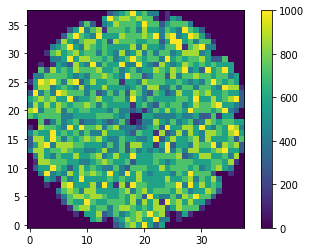

In [48]:
_ = counts / bin_area
pl.imshow(_,origin='lower',vmin=0,vmax=1000)
pl.colorbar()

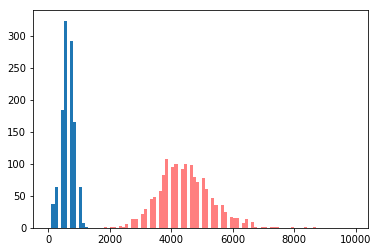

In [79]:
pl.hist(np.ravel(counts[counts>0])/bin_area,bins=np.arange(0.0,2000.0,100));
pl.hist(np.ravel(mtl_counts[mtl_counts>0])/bin_area,bins=np.arange(0,10000,100),color='r',alpha=0.5);

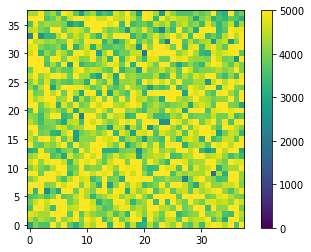

In [46]:
_ = mtl_counts / bin_area
pl.imshow(_,origin='lower',vmin=0,vmax=5000)
pl.colorbar()

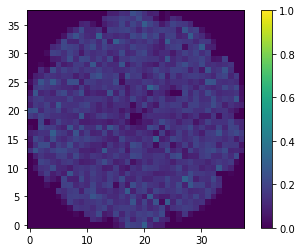

In [108]:
_ = np.zeros_like(counts)
_[mtl_counts > 0] = counts[mtl_counts>0]/mtl_counts[mtl_counts>0]
pl.imshow(_,origin='lower',vmin=0,vmax=1)
pl.colorbar()

1143


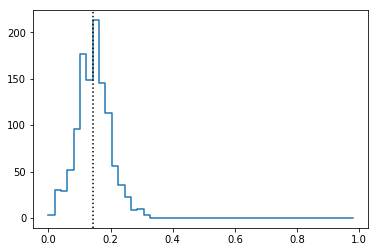

In [134]:
_     = np.zeros_like(counts)
ok    = (counts > 0) & (mtl_counts > 0)
_[ok] = counts[ok]/mtl_counts[ok]
_     = _[ok].ravel()
print(ok.sum())
h,b = np.histogram(_,bins=np.linspace(0,1,50))
pl.plot(b[:-1],h,drawstyle='steps-post')
pl.axvline(np.median(_),c='k',ls=':')